In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import panel as pn
import plotly.express as px
import os
from requests import api 
from dotenv import load_dotenv
from pycoingecko import CoinGeckoAPI


pn.extension("plotly")

## Get the national currencies for countries

In [2]:
country_currency = api.get('http://country.io/currency.json').json()

# countries2 = api.get('https://restcountries.eu/rest/v2/').json()
# countries2

In [3]:
df_country_currency = pd.DataFrame(columns=['Code', 'Curr_code'], dtype=object)
for key,value in country_currency.items():
    df_country_currency = df_country_currency.append(pd.Series(
    [
        key,
        value
    ], index= df_country_currency.columns ), ignore_index=True)

In [4]:
df_country_currency.set_index('Code',inplace=True)
df_country_currency.head()

Curr_code
Code          
BD         BDT
BE         EUR
BF         XOF
BG         BGN
BA         BAM

# Get the countries data - geocodes, currency codes, etc, saved in a CSV - concap.csv

In [5]:
df_country_geocodes = pd.read_csv('Data/concap.csv', index_col=None)
df_country_geocodes.dropna(inplace=True)
df_country_geocodes.set_index('CountryCode', inplace=True)

# Concatenate the 2 DFs together to have the data in the foll, format:
CountryCode|CountryName|CapitalName|CapitalLatitude|CapitalLongitude|ContinentName|Curr_code
---|---|---|---|---|---|---|
AU|Australia|Canberra|-35.2667|149.133|Australia|AUD

In [6]:
df_country_data = pd.concat([df_country_geocodes, df_country_currency], axis='columns', join='inner')
df_country_data.loc['AU']

CountryName         Australia
CapitalName          Canberra
CapitalLatitude      -35.2667
CapitalLongitude      149.133
ContinentName       Australia
Curr_code                 AUD
Name: AU, dtype: object

In [7]:
# Saving the data to CSV, we can just start with the CSVs in the final project code
df_country_data.to_csv('Data/Country_data.csv')

## Just a test to display the data obtained so far

In [8]:
load_dotenv()
map_box_api = os.getenv("MAPBOX_PUBLIC")

# Set the Mapbox API
px.set_mapbox_access_token(map_box_api)

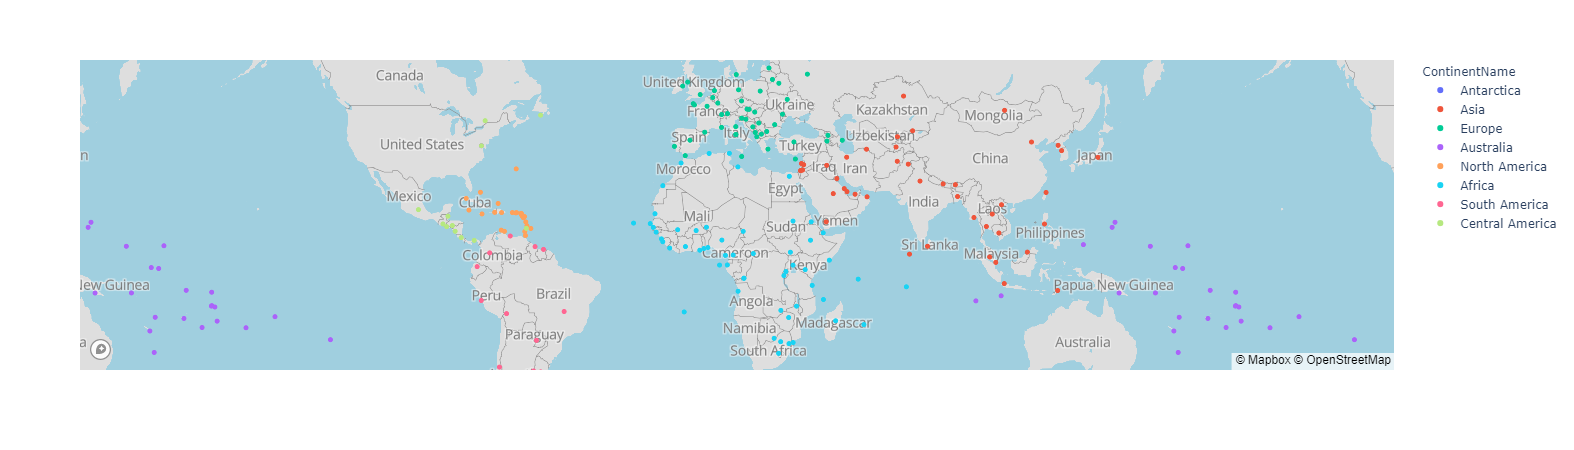

In [9]:
hover_data = {'ContinentName': False, 'CountryName':False, 'CapitalLatitude':False, 'CapitalLongitude':False, 'Curr_code':True}

map1 = px.scatter_mapbox(
    df_country_data,
    lat="CapitalLatitude",
    lon="CapitalLongitude",
    color="ContinentName",
    hover_name='CountryName',
    hover_data= hover_data, #['CapitalName', 'Curr_code' ],
    zoom = 1,
    mapbox_style='basic'
)
map1.show()

In [10]:
df_country_data.loc[df_country_data.Curr_code == 'DOP']

CountryName    CapitalName  CapitalLatitude  CapitalLongitude  \
DO  Dominican Republic  Santo Domingo        18.466667             -69.9   

    ContinentName Curr_code  
DO  North America       DOP

# Getting the crypto data - This will be used in the final project code

In [11]:
# form the list of fiat currencies - We need to use this to call the coingecko API
fiat = df_country_data.Curr_code.to_list()

In [12]:
gecko = CoinGeckoAPI()
crypto_prices = gecko.get_price(ids=['bitcoin','litecoin', 'ripple'], vs_currencies=fiat, include_market_cap=True, include_24hr_vol=True, include_24hr_change=True)

In [13]:
df_gecko_data = pd.DataFrame.from_dict(crypto_prices)
df_gecko_data.index = df_gecko_data.index.str.upper()
df_gecko_data.head()

bitcoin        ripple      litecoin
AED             1.234000e+05  2.430000e+00  5.017000e+02
AED_24H_CHANGE -4.637510e+00 -3.968176e+00 -4.198995e+00
AED_24H_VOL     1.108804e+11  1.110602e+10  9.066666e+09
AED_MARKET_CAP  2.306728e+12  1.118910e+11  3.344405e+10
ARS             3.215646e+06  6.328000e+01  1.307374e+04

## We will be forming 3 DFs from the data received

1. df_cryp_prices: will have the currency codes as the index, columns as the crypto names, and will store the current prices

2. df_cryp_change: will have the currency codes as the index, columns as the crypto names, and will store the changes over 24Hours. There will also be a col for Average change

3. df_cryp_vol: will have the currency codes as the index, columns as the crypto names, and will store the volume over 24Hours. There will also be a col for Average volume

In [14]:
crypto_names = df_gecko_data.columns.to_list()

In [15]:
df_cryp_prices = pd.DataFrame(columns= (['Curr'] + crypto_names)).set_index('Curr')

cols_change =['Curr']
for a in crypto_names: cols_change += [f'{a}_chg']
cols_change += ['Score_chg']
df_cryp_change = pd.DataFrame(columns=cols_change)

cols_vol =['Curr']
for a in crypto_names:  cols_vol += [f'{a}_vol']
cols_vol += ['Score_vol']
df_cryp_vol = pd.DataFrame(columns= cols_vol)
df_cryp_vol.columns

Index(['Curr', 'bitcoin_vol', 'ripple_vol', 'litecoin_vol', 'Score_vol'], dtype='object')

### Populate the dataframes

In [16]:
row_2 = []
for row in df_gecko_data.index:
    
    row_data = df_gecko_data.loc[row]
    
    if len(row) == 3:
        df_cryp_prices = df_cryp_prices.append(row_data)
        
    elif '_24H_CHANGE' in row:
        row_2 = [row[0:3]]
        row_2.extend(row_data)
        avg = np.average(row_data)
        row_2.extend([np.average(row_data)])
        
        df_cryp_change = df_cryp_change.append(pd.Series(row_2, index= df_cryp_change.columns), ignore_index=True)
        
    elif '_24H_VOL' in row:
        row_2 = [row[0:3]]
        row_2.extend(row_data)
        avg = np.average(row_data)
        row_2.extend([np.average(row_data)])
        
        df_cryp_vol = df_cryp_vol.append(pd.Series(row_2, index= df_cryp_vol.columns), ignore_index=True)

In [17]:
df_cryp_change.set_index('Curr', inplace= True)
df_cryp_vol.set_index('Curr', inplace= True)
print(df_cryp_prices.head())
print(df_cryp_change.head())
print(df_cryp_vol.head())

         bitcoin     ripple  litecoin
Curr                                 
AED    123400.00   2.430000    501.70
ARS   3215646.00  63.280000  13073.74
AUD     44850.00   0.882619    182.35
BDT   2850110.00  56.090000  11587.60
BHD     12665.46   0.249248     51.49
      bitcoin_chg  ripple_chg  litecoin_chg  Score_chg
Curr                                                  
AED     -4.637510   -3.968176     -4.198995  -4.268227
ARS     -4.547753   -3.877789     -4.108825  -4.178122
AUD     -4.508756   -3.838519     -4.069649  -4.138975
BDT     -4.643532   -3.974241     -4.205045  -4.274273
BHD     -4.645102   -3.975822     -4.206623  -4.275849
       bitcoin_vol    ripple_vol  litecoin_vol     Score_vol
Curr                                                        
AED   1.108804e+11  1.110602e+10  9.066666e+09  4.368435e+10
ARS   2.889400e+12  2.894087e+11  2.362657e+11  1.138358e+12
AUD   4.029978e+10  4.036514e+09  3.295306e+09  1.587720e+10
BDT   2.560951e+12  2.565104e+11  2.094085e+

In [18]:
(1.119524e+11 + 1.328155e+10 +  9.443507e+09 ) / 3

44892485666.666664

In [19]:
df_crypto_complete = pd.concat([df_cryp_prices, df_cryp_change, df_cryp_vol], axis='columns', join='inner')

In [20]:
print(df_crypto_complete.head())

         bitcoin     ripple  litecoin  bitcoin_chg  ripple_chg  litecoin_chg  \
Curr                                                                           
AED    123400.00   2.430000    501.70    -4.637510   -3.968176     -4.198995   
ARS   3215646.00  63.280000  13073.74    -4.547753   -3.877789     -4.108825   
AUD     44850.00   0.882619    182.35    -4.508756   -3.838519     -4.069649   
BDT   2850110.00  56.090000  11587.60    -4.643532   -3.974241     -4.205045   
BHD     12665.46   0.249248     51.49    -4.645102   -3.975822     -4.206623   

      Score_chg   bitcoin_vol    ripple_vol  litecoin_vol     Score_vol  
Curr                                                                     
AED   -4.268227  1.108804e+11  1.110602e+10  9.066666e+09  4.368435e+10  
ARS   -4.178122  2.889400e+12  2.894087e+11  2.362657e+11  1.138358e+12  
AUD   -4.138975  4.029978e+10  4.036514e+09  3.295306e+09  1.587720e+10  
BDT   -4.274273  2.560951e+12  2.565104e+11  2.094085e+11  1.008956e+

## Forming the dataframe which can be sent for plotting

In [21]:
col_names_plotting = ['Curr'] + crypto_names + ['Score_chg', 'Score_vol']
df_crypto_print = pd.DataFrame(columns= col_names_plotting)
df_crypto_print

Empty DataFrame
Columns: [Curr, bitcoin, ripple, litecoin, Score_chg, Score_vol]
Index: []

In [23]:
# Maybe we can use u'\u2191' in the price text to display up-arrow and u'\u2193' for down arrow

for row in df_crypto_complete.index:
    
    row_print = [row]
    
    for name in crypto_names:
        
        col_name = name
        
        price_val = df_crypto_complete.loc[row][col_name]
        
        change_val = df_crypto_complete.loc[row][f'{col_name}_chg']
        
        vol_val = df_crypto_complete.loc[row][f'{col_name}_vol']
        
        price = "Price:  {:,.2f}".format(price_val) + ", Change: {:,.2f}".format(change_val) + ", Volume: {:,.2f}".format(vol_val)
        
        row_print += [price]
#         print(price)
        
    row_print += [df_crypto_complete.loc[row]['Score_chg']] + [df_crypto_complete.loc[row]['Score_vol']] 
#     print(row_print)
    df_crypto_print = df_crypto_print.append(pd.Series(row_print, index= df_crypto_print.columns), ignore_index=True)

In [24]:
df_crypto_print.set_index('Curr', inplace= True)

In [25]:
print(df_crypto_print.head())

                                                bitcoin  \
Curr                                                      
AED   Price: 123,400.00, Change: -4.64, Volume: 110,...   
ARS   Price: 3,215,646.00, Change: -4.55, Volume: 2,...   
AUD   Price: 44,850.00, Change: -4.51, Volume: 40,29...   
BDT   Price: 2,850,110.00, Change: -4.64, Volume: 2,...   
BHD   Price: 12,665.46, Change: -4.65, Volume: 11,38...   

                                                 ripple  \
Curr                                                      
AED   Price: 2.43, Change: -3.97, Volume: 11,106,019...   
ARS   Price: 63.28, Change: -3.88, Volume: 289,408,6...   
AUD   Price: 0.88, Change: -3.84, Volume: 4,036,514,...   
BDT   Price: 56.09, Change: -3.97, Volume: 256,510,4...   
BHD   Price: 0.25, Change: -3.98, Volume: 1,139,893,...   

                                               litecoin  Score_chg  \
Curr                                                                 
AED   Price: 501.70, Change: -4.

In [26]:
df_plot = df_country_data.merge(df_crypto_print, left_on='Curr_code', right_index=True, how='inner')

In [27]:
df_plot.head()

CountryName        CapitalName  \
GS  South Georgia and South Sandwich Islands  King Edward Point   
GS  South Georgia and South Sandwich Islands  King Edward Point   
GG                                  Guernsey   Saint Peter Port   
GG                                  Guernsey   Saint Peter Port   
IM                               Isle of Man            Douglas   

    CapitalLatitude  CapitalLongitude ContinentName Curr_code  \
GS       -54.283333        -36.500000    Antarctica       GBP   
GS       -54.283333        -36.500000    Antarctica       GBP   
GG        49.450000         -2.533333        Europe       GBP   
GG        49.450000         -2.533333        Europe       GBP   
IM        54.150000         -4.483333        Europe       GBP   

                                              bitcoin  \
GS  Price: 24,341.00, Change: -4.47, Volume: 21,87...   
GS  Price:  24,341.00↑, Change: -4.47, Volume: 21,...   
GG  Price: 24,341.00, Change: -4.47, Volume: 21,87...   
GG  Price:  24,341.00↑, Change: -4.47, Volume: 21,...   
IM  Price: 24,341.00, Change: -4.47, Volume: 21,87...   

                                               ripple  \
GS  Price: 0.48, Change: -3.80, Volume: 2,190,732,...   
GS  Price:  0.48↑, Change: -3.80, Volume: 2,190,73...   
GG  Price: 0.48, Change: -3.80, Volume: 2,190,732,...   
GG  Price:  0.48↑, Change: -3.80, Volume: 2,190,73...   
IM  Price: 0.48, Change: -3.80, Volume: 2,190,732,...   

                                             litecoin  Score_chg     Score_vol  
GS  Price: 98.96, Change: -4.03, Volume: 1,788,457...  -4.099085  8.617014e+09  
GS  Price:  98.96↑, Change: -4.03, Volume: 1,788,4...  -4.099085  8.617014e+09  
GG  Price: 98.96, Change: -4.03, Volume: 1,788,457...  -4.099085  8.617014e+09  
GG  Price:  98.96↑, Change: -4.03, Volume: 1,788,4...  -4.099085  8.617014e+09  
IM  Price: 98.96, Change: -4.03, Volume: 1,788,457...  -4.099085  8.617014e+09

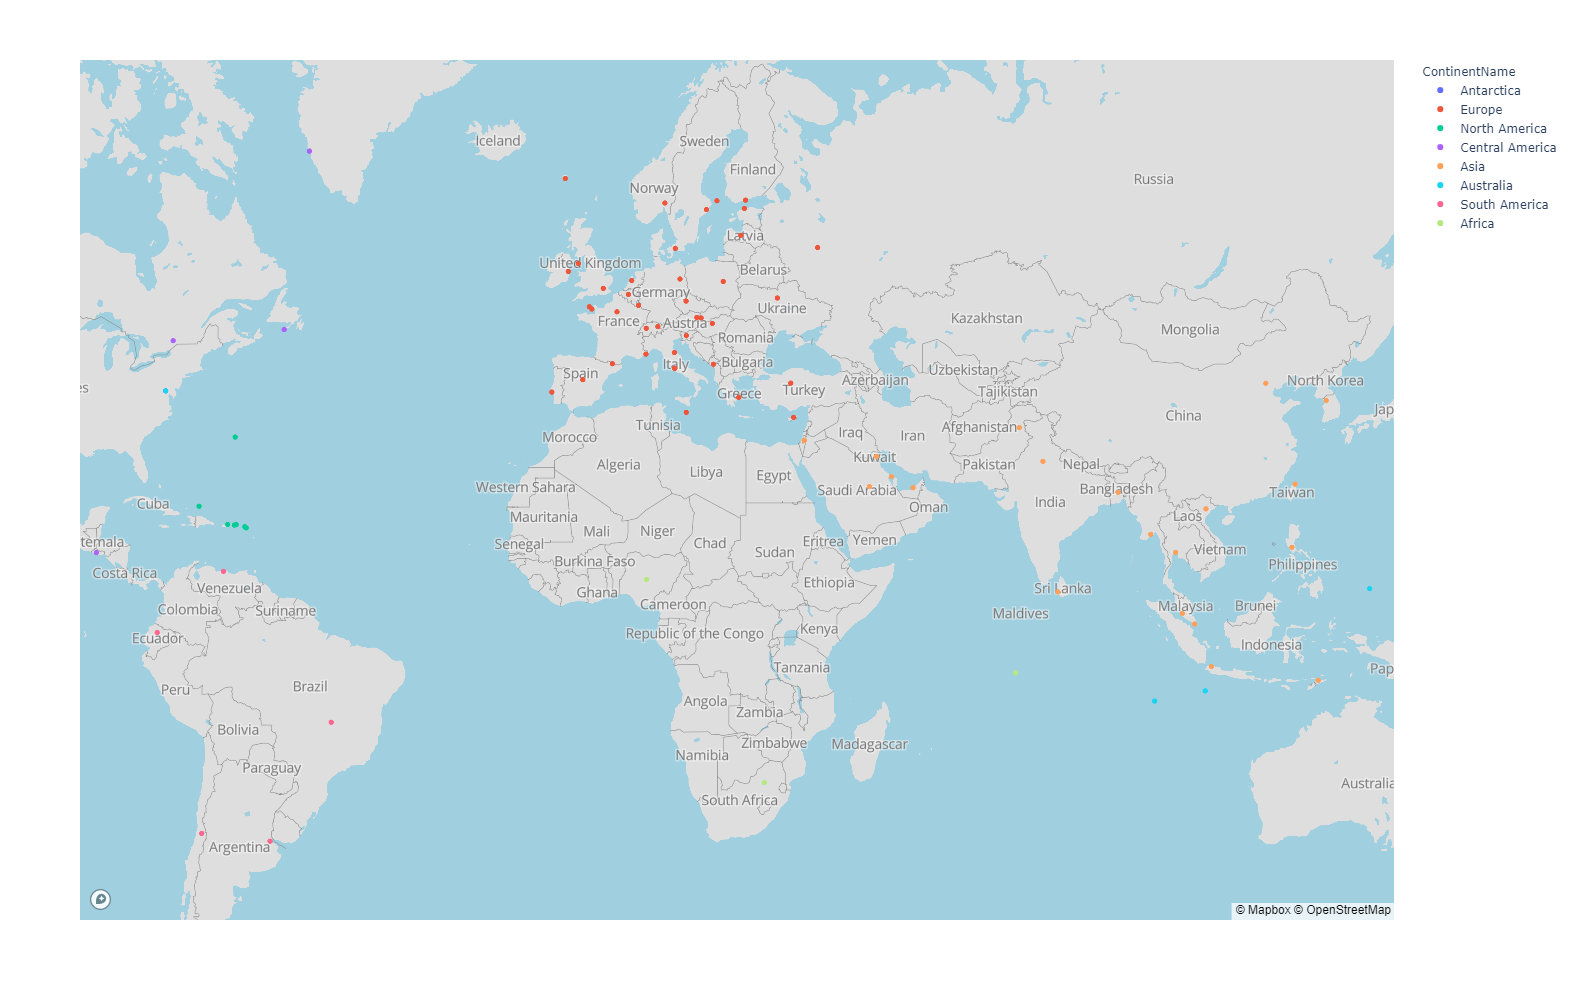

In [28]:
hover_data = {'ContinentName': False, 'CountryName':False, 'CapitalLatitude':False, 'CapitalLongitude':False, 'Curr_code':True,
              'ripple': True, 'bitcoin': True, 'litecoin':True}

map1 = px.scatter_mapbox(
    df_plot,
    lat="CapitalLatitude",
    lon="CapitalLongitude",
    color="ContinentName",
    hover_name='CountryName',
    hover_data= hover_data, #['CapitalName', 'Curr_code' ],
    zoom = 2,
    mapbox_style='basic',
    height=1000
)
map1.show()

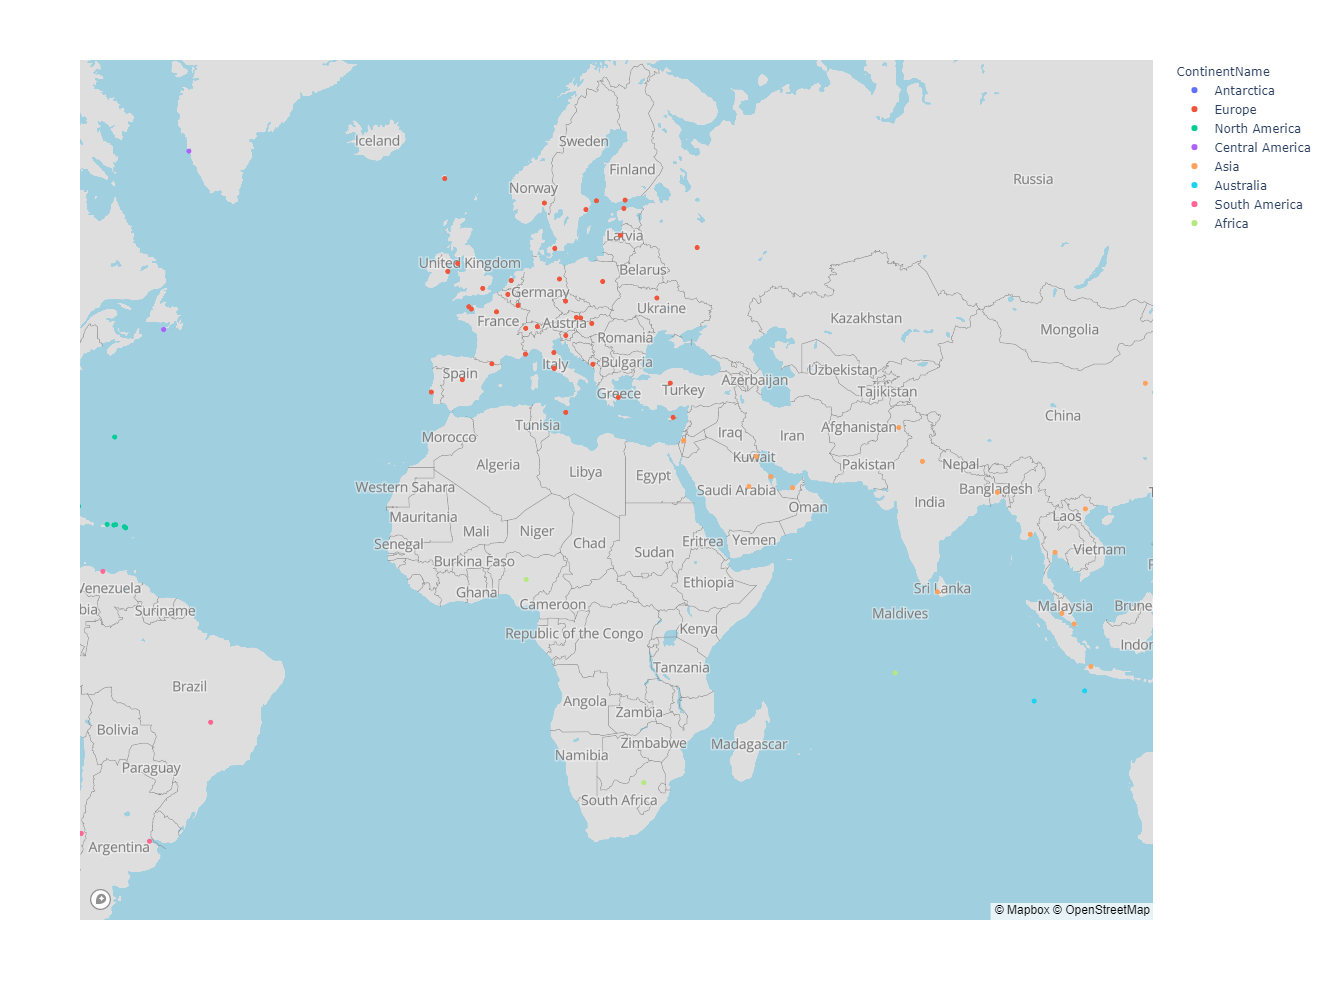

In [28]:


map2 = px.scatter_mapbox(
    df_plot,
    lat="CapitalLatitude",
    lon="CapitalLongitude",
    color="ContinentName",
    size='Score_vol',
    hover_name='CountryName',
    hover_data= hover_data, #['CapitalName', 'Curr_code' ],
    zoom = 1,
    mapbox_style='basic'
)
map1.show()

In [29]:
# Adding columns to the dataframe
col_zero = [0] * len(df_prices)
cols = df_prices.columns
for s in cols:
    col_name = f'{s}_24H_CHANGE'
    df_prices[col_name] = col_zero

df_prices['Score'] = col_zero
df_prices.head()
# df_prices.loc[df_prices.index ]

NameError: name 'df_prices' is not defined

In [ ]:
# just trying to search for all rows which have the pattern *_24H_CHANGE
import re
df_prices.loc[df_prices.index.str.contains('_24H_CHANGE')]


In [ ]:
# Setting the change values in the dataframe
import re

index = 0
for c in cols:
    for row in df_prices.index:
        if len(row) == 3:
            curr = row
            new_col_name = f'{c}_24H_CHANGE'
            df_prices.loc[row,new_col_name] = df_prices.loc[f'{curr}_24H_CHANGE', c]
#                 print(new_col_name)

for row in df_prices.index:
    
    total = 0
    num = 0
    
    for c in df_prices.columns:
        
#         if c.contains('_24H_CHANGE'):
        if re.search('.+_24H_CHANGE', c) :
            total += df_prices.loc[row, c]
            num += 1
    
    
    df_prices.loc[row, 'Score'] = total / num

In [ ]:
df_prices.head()

In [ ]:
df_prices.loc[df_prices.index.str.contains('_24H_CHANGE')]


In [ ]:
df_country_data.head()

In [ ]:
# df_concatenated = pd.concat([df_country_data, df_prices], )

In [ ]:
df_concat = df_country_data.merge(df_prices, left_on='Curr_code', right_index=True, how='inner')

In [ ]:
(-5.177703 + -4.284477 + -6.774659 ) / 3

In [ ]:
hover_data = {'ContinentName': False, 'CountryName':False, 'CapitalLatitude':False, 'CapitalLongitude':False, 'Curr_code':True,
             'bitcoin': True, 'litecoin':True, 'bitcoin_24H_CHANGE': True, 'litecoin_24H_CHANGE': True}

map1 = px.scatter_mapbox(
    df_concat,
    lat="CapitalLatitude",
    lon="CapitalLongitude",
    color="ContinentName",
    hover_name='CountryName',
    hover_data= hover_data, #['CapitalName', 'Curr_code' ],
    zoom = 1,
    mapbox_style='basic'
)
map1.show()